# Audio関係のお勉強。流れ星を捕まえたい。その①

目標：「あつ森」で流れ星の音を判定したい

参考：https://jorublog.site/python-voice-analysis/

note版
https://note.com/rasen/n/nc6f46e52d4f7

ーー

## 準備

まず最初に、必要なモジュールをインストールします。

pip install numpy
pip install librosa
pip install matplotlib
pip install scipy 



# 音声データを表示
まず最初に音声データの中身をそのまま表示してみます。



In [4]:
# ワーニングをカットしてみたものの、あまり意味がな買った模様
import warnings
warnings.filterwarnings('ignore')

参考サイトのソースそのままでやってみると

16000
<class 'numpy.ndarray'>


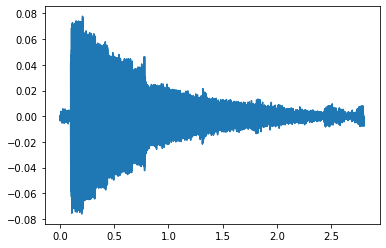

In [55]:
import sys
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt

#音声ファイル読み込み
#args = sys.argv
#wav_filename = args[1]
#rate, data = scipy.io.wavfile.read("star0_R2_m.wav") # bad data
rate, data = scipy.io.wavfile.read("Interphone.wav") # Good data

print(rate)
print(type(data))

##### 音声データをそのまま表示する #####
#縦軸（振幅）の配列を作成   #16bitの音声ファイルのデータを-1から1に正規化
data = data / 32768
#横軸（時間）の配列を作成　　#np.arange(初項, 等差数列の終点, 等差)
time = np.arange(0, data.shape[0]/rate, 1/rate)  
#データプロット
plt.plot(time, data)
plt.show()


サイトから落としてきたＧｏｏｄデータでは問題なく表示されるけれど、自分で作成したWavファイルだと

Chunk (non-data) not understood 

エラーとなる。

チャンクが理解できない？？　Wavファイルはほかのプレイヤーでは再生できるし、問題なさそうなのだけれど……。
試しにモノラルにして読ませてもダメ、同じエラーになる。

https://mediaarea.net/ja/MediaInfo
でもとのオーディオファイルを測定。

<img src="2020-06-26_19h45_41.png">

とある。

これに合わせてファイルを作成したみたがダメ。どういうことかしらん？


仕方がないのでエラーを出している scipy.io.wavfile を諦め、 import wave をして
waveを使ってwavデータをファイルから愚直に取得。np.frombufferでnp形式に変更することにする。

参考：https://deepage.net/features/numpy-frombuffer.html


_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=23406, comptype='NONE', compname='not compressed')
23406
44100
<class 'bytes'>


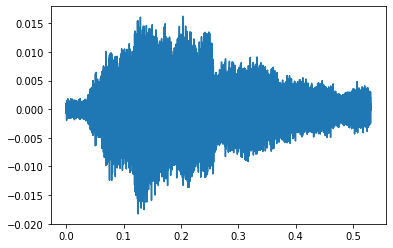

In [34]:
import wave
    
#wave_file = "/path/to/wave/file"
wf = wave.open("star0_R2.wav")
channels = wf.getnchannels()
print(wf.getparams())

chunk_size = wf.getnframes()
print(chunk_size)

#data = wf.readframes(wf.getnframes())
data = wf.readframes(chunk_size) # まずは読み取ったファイルの全てを格納する。

wf.close()

data2 = np.frombuffer(data, dtype = 'int16')


#rate = 16000
rate = wf.getframerate()

print(rate)
print(type(data))

##### 音声データをそのまま表示する #####
#縦軸（振幅）の配列を作成   #16bitの音声ファイルのデータを-1から1に正規化
data2 = data2 / 32768
#横軸（時間）の配列を作成　　#np.arange(初項, 等差数列の終点, 等差)
time = np.arange(0, data2.shape[0]/rate, 1/rate)  
#データプロット
plt.plot(time, data2)
plt.show()

これでようやく成功。

冒頭を１０００倍してみるとかも問題なし（あまり意味がない）

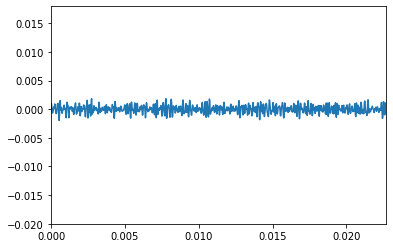

In [35]:
#データプロット
plt.plot(time, data2)
plt.xlim(0, 1000/rate)
plt.show()

## 周波数成分を表示

続いてフーリエ変換して周波数成分を表示させる。


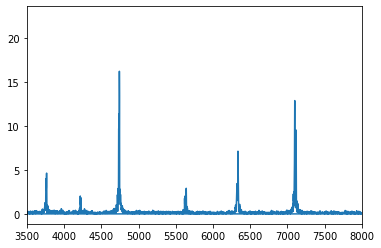

In [36]:
#（振幅）の配列を作成
#data = data / 32768
 
##### 周波数成分を表示する #####
#縦軸：dataを高速フーリエ変換する（時間領域から周波数領域に変換する）
fft_data = np.abs(np.fft.fft(data2))
#横軸：周波数の取得　　#np.fft.fftfreq(データ点数, サンプリング周期)
freqList = np.fft.fftfreq(data2.shape[0], d=1.0/rate)
#データプロット
plt.plot(freqList, fft_data)
plt.xlim(3500, 8000) #3500～8000Hzまで表示
plt.show()

In [ ]:
## 特徴点を抜き出してみる

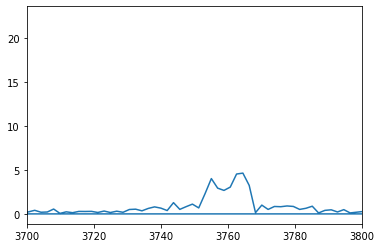

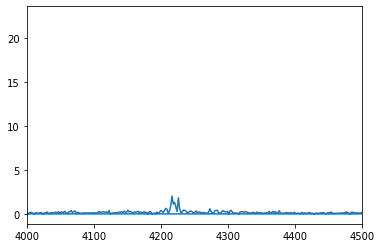

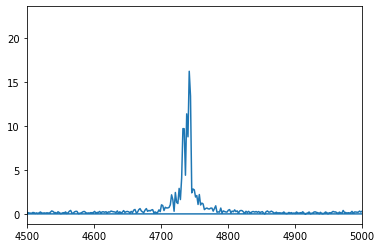

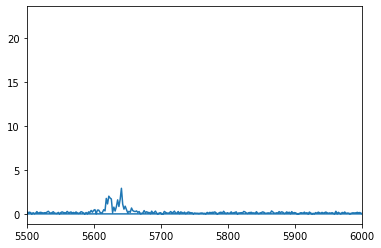

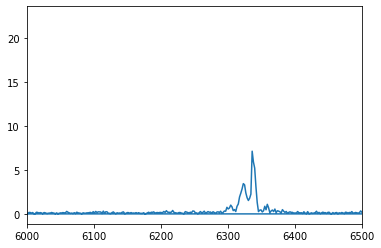

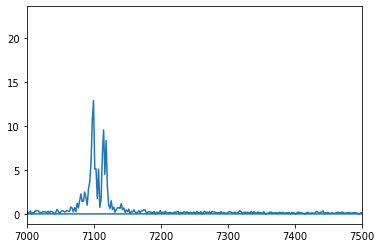

In [53]:
plt.plot(freqList, fft_data)
plt.xlim(3700, 3800)
plt.show()

plt.plot(freqList, fft_data)
plt.xlim(4000, 4500)
plt.show()

plt.plot(freqList, fft_data)
plt.xlim(4500, 5000)
plt.show()

plt.plot(freqList, fft_data)
plt.xlim(5500, 6000)
plt.show()

plt.plot(freqList, fft_data)
plt.xlim(6000, 6500)
plt.show()

plt.plot(freqList, fft_data)
plt.xlim(7000, 7500)
plt.show()


↑の６点の音をチェックして、それなりの入力があったら流れ星が発生したと判定するプログラムを作ればよい、ということ。

そこらへんをグラフィックで表示してくれる

# スペクトラム表示
をやってみる。

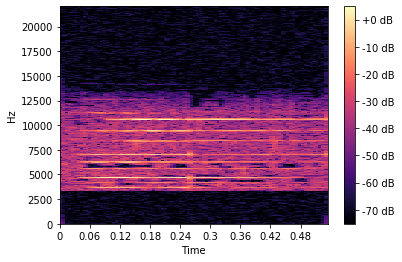

In [37]:
import librosa.display

# フレーム長
fft_size = 1024                 
# フレームシフト長 
hop_length = int(fft_size / 4)  


# 短時間フーリエ変換実行
amplitude = np.abs(librosa.core.stft(data2, n_fft=fft_size, hop_length=hop_length))
 
# 振幅をデシベル単位に変換
log_power = librosa.core.amplitude_to_db(amplitude)
 
# グラフ表示
librosa.display.specshow(log_power, sr=rate, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')  
plt.show()                        
